In [6]:
import matplotlib.pyplot as plt
from rnpe.utils import get_manual_legend, pairplot
import seaborn as sns
import pickle
import numpy as np

sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_style('whitegrid', {'font.family':'Times New Roman', 'font.serif':'serif', "font.size": 11})
colors = ["#072D41", "#ECA918", "#60B3C8", "#359735"]
plt.rcParams['axes.axisbelow'] = True


### SIR Barplot

In [7]:
f_name = f"../results/sirsde/0.pickle"
with open(f_name, "rb") as f:
    res = pickle.load(f)

def rescale_results(res):
    x_mean, x_std = res["scales"]["x_mean"], res["scales"]["x_std"]
    theta_mean, theta_std = res["scales"]["theta_mean"], res["scales"]["theta_std"]

    res["data"]["x"] = res["data"]["x"] * x_std + x_mean
    res["data"]["y"] = res["data"]["y"] * x_std + x_mean
    res["data"]["theta"] = res["data"]["theta"] * theta_std + theta_mean
    res["data"]["theta_true"] = res["data"]["theta_true"] * theta_std + theta_mean
    res["mcmc_samples"]["x"] = res["mcmc_samples"]["x"] * x_std + x_mean

    res["posterior_samples"]["NPE"] = res["posterior_samples"]["NPE"] * theta_std + theta_mean
    res["posterior_samples"]["Robust NPE"] = res["posterior_samples"]["Robust NPE"] * theta_std + theta_mean


rescale_results(res)

misspecified = res["mcmc_samples"]["misspecified"].mean(axis=0)
order = np.argsort(misspecified)
misspecified = misspecified[order]

pretty_names = {
    "log_half_total_reached_at": "Half I Day",
    "log_max_infections": "Max I",
    "log_mean": "Mean I",
    "log_max_infections_day": "Max I Day",
    "log_median": "Median I",
    "autocor_lag1": "Autocor",
}

names = [pretty_names[res["names"]["x"][i]] for i in order]


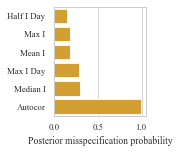

In [8]:
plt.figure(figsize=(5.5*3/10, 2))
ax = sns.barplot(x=misspecified, y=names, color=colors[1])
ax.set_xlabel("Posterior misspecification probability")
plt.savefig("../results/plots/sir_bar.pdf", bbox_inches="tight")


In [9]:
n = 10000
autocor_idx = res["names"]["x"].index("autocor_lag1")
import pandas as pd
denoised = pd.DataFrame({
        "Simulations": np.random.permutation(res["data"]["x"])[:n, autocor_idx],
        "Denoised": np.random.permutation(res["mcmc_samples"]["x"])[:n, autocor_idx]
    })
denoised = denoised.melt(value_name="Autocor", var_name="Source")

def scale_autocor(a):
    return a*res["scales"]["x_std"][autocor_idx] + res["scales"]["x_mean"][autocor_idx]

denoised["Autocor"] = scale_autocor(denoised["Autocor"])
denoised["Source"] = pd.Categorical(denoised["Source"], ["Simulations", "Denoised"])
obs_autocor = scale_autocor(res["data"]["y"][autocor_idx])

/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 1.65 x 2 in image.
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../results/plots/sir_autocor_density.pdf


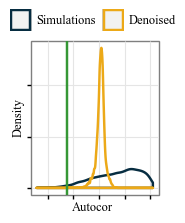

<ggplot: (8746844197690)>

In [10]:
import plotnine as p9
lw = 1
font_kwargs = {"family": "Times New Roman", "size": 9}
breaks = [denoised["Autocor"].min(), denoised["Autocor"].max()]
p = (
p9.ggplot(p9.aes(x="Autocor", color="Source", fill="Source"), denoised)
+ p9.geom_density(alpha=0, size=lw)
+ p9.theme_bw()
+ p9.scale_color_manual(values=[colors[0], colors[1]])
+ p9.scale_fill_manual(values=[colors[0], colors[1]])
+ p9.geom_vline(xintercept=obs_autocor, color=colors[-1], size=lw)
+ p9.ylab("Density")
+ p9.theme(
    legend_title=p9.element_blank(),
    figure_size=(5.5*3/10, 2),
    legend_position="top",
    legend_margin=-12,
    axis_text=p9.element_blank(),
    text=p9.element_text(**font_kwargs),
    panel_grid_minor=p9.element_blank()
    )
)
p.save("../results/plots/sir_autocor_density.pdf")
p

In [11]:
thetas_d = {
    "Prior": res["data"]["theta"],
    "NPE": res["posterior_samples"]["NPE"],
    "RNPE": res["posterior_samples"]["Robust NPE"]}

thetas = []
for source, samples in thetas_d.items():
    thetas.append(
        pd.DataFrame({
            r"$\beta$": samples[:, 0],
            r"$\gamma$": samples[:, 1],
            "Source": source
        })
    )

thetas = pd.concat(thetas)

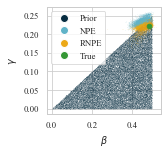

In [12]:
cols = [colors[0], colors[2], colors[1], colors[3]]
plt.figure(figsize=(5.5*4/10, 2))
for (k, v), color in zip(thetas_d.items(), cols):
    plt.scatter(x=v[:, 0], y=v[:, 1], s=0.001, color=color, label=k, rasterized=True)
plt.scatter(x = res["data"]["theta_true"][0], y = res["data"]["theta_true"][1], color=cols[-1])

handles = get_manual_legend(list(thetas_d.keys()) + ["True"], cols)
plt.legend(handles=handles)
plt.tight_layout()
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\gamma$")
plt.savefig("../results/plots/sir_posterior.pdf", dpi=500, bbox_inches="tight")


### SIR Denoised

In [13]:


keep = ["log_mean", "log_max_infections", "autocor_lag1"]
new_names = ["Log Mean", "Log Max", "Autocor"]
keep_idx = [res["names"]["x"].index(n) for n in keep]

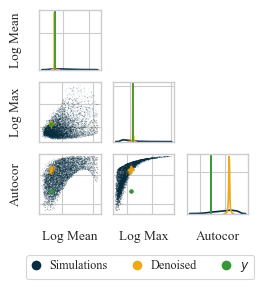

In [14]:
f_name = f"../results/sirsde/1.pickle"
with open(f_name, "rb") as f:
    res = pickle.load(f)

n = 10000
denoised = {
        "Simulations": np.random.permutation(res["data"]["x"])[:n, keep_idx],
        "Denoised": np.random.permutation(res["mcmc_samples"]["x"])[:n, keep_idx]
        }

p = pairplot(
    denoised,
    res["data"]["y"][keep_idx],
    col_names=new_names,
    true_name=r"$y$",
    colors=[colors[i] for i in range(len(colors)) if i!=2],
    legend_y_adjust = -0.14,
    array_point_size = 0.4,
    true_point_size = 5,
    legend_kws=dict(handletextpad=0.8, handlelength = 0.7)
    )

p.set_size_inches(2.7, 2.7)
p.savefig("../results/plots/sir_denoised.pdf", bbox_inches='tight', dpi=500)

### SIR Posterior

In [15]:
posteriors = {
        "Prior": res["data"]["theta"][:n],
        "NPE": res["posterior_samples"]["NPE"][:n],
        "RNPE": res["posterior_samples"]["Robust NPE"][:n],
    }

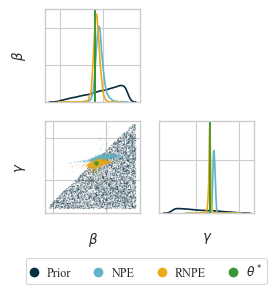

In [16]:
p = pairplot(
        posteriors,
        res["data"]["theta_true"],
        col_names=[r"$\beta$", r"$\gamma$"],
        true_name=r"$\theta^*$",
        colors=[colors[0], colors[2], colors[1], colors[3]],
        array_point_size = 0.6,
        true_point_size = 5,
        legend_y_adjust = -0.16,
        legend_kws=dict(handletextpad=0.8, handlelength = 0.5)
        )

p.set_size_inches(2.7, 2.7)

p.savefig("../results/plots/sir_posterior.pdf", bbox_inches='tight', dpi=500)

### NEW Try using MatPlotLib axes for all of them?

ValueError: Could not interpret value `Autocor` for parameter `x`

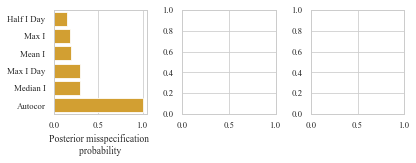

<Figure size 118.8x144 with 0 Axes>

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(5.5, 2))
plt.tight_layout()

# plot a
plt.figure(figsize=(5.5*3/10, 2))
sns.barplot(x=misspecified, y=names, color=colors[1], ax=ax[0])
ax[0].set_xlabel("Posterior misspecification \nprobability")

# plot b
sns.kdeplot(
    x = "Autocor",
    hue="Source",
    ax=ax[1],
    data=denoised,
    palette=[colors[2], colors[1]],
    )
ax[1].set_xticks([])
ax[1].set_yticks([])


# plot c
sns.scatterplot(
    x=r"$\beta$",
    y=r"$\gamma$",
    data=thetas,
    hue="Source",
    ax=ax[2],
    s=0.1,
    palette=[colors[0], colors[2], colors[1]]
)



NameError: name 'ax' is not defined